# Lap Time prediction for Formula 1 Spanish Grand Prix

This notebook implements predictive models to estimate F1 car lap times based on various factors such as tire type, weather conditions, and track state.

## Objectives
1. Load and preprocess data from FastF1 and OpenF1  
2. Perform feature engineering to enhance predictive capability  
3. Include analysis of tire degradation and pit stops  
4. Train predictive models (XGBoost and optionally a Neural Network)  
5. Evaluate performance and visualize results  


## 1. Modules Used

In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import fastf1
import joblib
import os
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import xgboost as xgb
import lightgbm as lgb
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset




In [84]:
# Configurations
# Plot configs
plt.style.use('ggplot')
sns.set(style="whitegrid")
# FastF1 config
fastf1.Cache.enable_cache('../f1-strategy/f1_cache')  
# Necessary dirs created if not exist
os.makedirs('../outputs/week3', exist_ok=True)
os.makedirs('../models/week3', exist_ok=True)

## 2. Model Definition

In [85]:
# Class for Pytorch Model
class LapTimeNN(nn.Module):
    def __init__(self, input_size):
        super(LapTimeNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )
    
    def forward(self, x):
        return self.model(x)

## 3. Data Loading and Preparation

We will load the data from the available Parquet files:

- **laps.parquet**: Contains information about individual laps  
- **weather.parquet**: Contains weather data  
- **intervals.parquet**: Contains information about gaps and race states  
- **pitstops.parquet**: Contains information about pit stops  


In [86]:
def load_all_data():
    """
    Load all the datasets from parquet arvhives, verifying duplicated values
    and returning them as Dataframes
    """
    # Define paths of the archives
    laps_path = "../f1-strategy/data/raw/Spain_2023_laps.parquet"
    weather_path = "../f1-strategy/data/raw/Spain_2023_weather.parquet"
    intervals_path = "../f1-strategy/data/raw/Spain_2023_openf1_intervals.parquet"
    pitstops_path = "../f1-strategy/data/raw/Spain_2023_pitstops.parquet"
    
    # Load Dataframes
    laps_df = pd.read_parquet(laps_path)
    weather_df = pd.read_parquet(weather_path)
    intervals_df = pd.read_parquet(intervals_path)
    pitstops_df = pd.read_parquet(pitstops_path)
    
    # Print info about possible duplicated values
    print("Verifying possible duplicated columns between datasets")
    
    # Compare columns 
    all_dfs = {
        'laps_df': laps_df,
        'weather_df': weather_df, 
        'intervals_df': intervals_df, 
        'pitstops_df': pitstops_df
    }
    
    for name1, df1 in all_dfs.items():
        for name2, df2 in all_dfs.items():
            if name1 >= name2:  # Avoid duplicated comparisons
                continue
                
            common_cols = set(df1.columns).intersection(set(df2.columns))
            if common_cols:
                print(f"Common columns between {name1} and {name2}: {common_cols}")
                
                # Verifying if columns have the same data
                for col in common_cols:
                    if col in df1.columns and col in df2.columns:
                        # For verifying only if they are in both datasets and have shared values
                        # For simplicity, only some values are compared 
                            value1 = df1[col].iloc[0] if len(df1) > 0 else None
                            value2 = df2[col].iloc[0] if len(df2) > 0 else None
                            print(f"  - Column '{col}': Example value in{name1} ------ {value1}, in {name2}: {value2}")
        
    
    return laps_df, weather_df, intervals_df, pitstops_df

In [87]:
# Load and unpack de data in different dataframes
laps_df, weather_df, intervals_df, pitstops_df = load_all_data()

Verifying possible duplicated columns between datasets
Common columns between laps_df and weather_df: {'Time'}
  - Column 'Time': Example value inlaps_df ------ 0 days 01:03:40.152000, in weather_df: 0 days 00:00:27.686000
Common columns between laps_df and pitstops_df: {'LapNumber', 'Team', 'Time', 'DriverNumber', 'TyreLife', 'IsPersonalBest', 'Sector2SessionTime', 'PitOutTime', 'Sector2Time', 'SpeedFL', 'Sector1SessionTime', 'FreshTyre', 'FastF1Generated', 'Sector3SessionTime', 'SpeedI1', 'SpeedST', 'SpeedI2', 'Sector3Time', 'LapStartDate', 'Position', 'Driver', 'PitInTime', 'IsAccurate', 'Compound', 'Sector1Time', 'LapStartTime', 'Stint', 'LapTime', 'DeletedReason', 'TrackStatus', 'Deleted'}
  - Column 'LapNumber': Example value inlaps_df ------ 1.0, in pitstops_df: 26.0
  - Column 'Team': Example value inlaps_df ------ Red Bull Racing, in pitstops_df: Red Bull Racing
  - Column 'Time': Example value inlaps_df ------ 0 days 01:03:40.152000, in pitstops_df: 0 days 01:37:09.530000
  -

In [88]:
# Show info about shape of the datafarmes

print(f"laps_df shape: {laps_df.shape} \n")

print(f"weather_df shape: {weather_df.shape} \n")

print(f"intervals_df shape: {intervals_df.shape} \n")

print(f"pitstops_df shape: {pitstops_df.shape} \n")



laps_df shape: (1312, 31) 

weather_df shape: (154, 8) 

intervals_df shape: (8933, 10) 

pitstops_df shape: (43, 31) 



In [89]:
paths = {
    "laps": "../f1-strategy/data/raw/Spain_2023_laps.parquet",
    "weather": "../f1-strategy/data/raw/Spain_2023_weather.parquet",
    "intervals": "../f1-strategy/data/raw/Spain_2023_openf1_intervals.parquet",
    "pitstops": "../f1-strategy/data/raw/Spain_2023_pitstops.parquet"
}

for name, path in paths.items():
    print(f"Columns of  {name}: {pd.read_parquet(path).columns.tolist()}")


Columns of  laps: ['Time', 'Driver', 'DriverNumber', 'LapTime', 'LapNumber', 'Stint', 'PitOutTime', 'PitInTime', 'Sector1Time', 'Sector2Time', 'Sector3Time', 'Sector1SessionTime', 'Sector2SessionTime', 'Sector3SessionTime', 'SpeedI1', 'SpeedI2', 'SpeedFL', 'SpeedST', 'IsPersonalBest', 'Compound', 'TyreLife', 'FreshTyre', 'Team', 'LapStartTime', 'LapStartDate', 'TrackStatus', 'Position', 'Deleted', 'DeletedReason', 'FastF1Generated', 'IsAccurate']
Columns of  weather: ['Time', 'AirTemp', 'Humidity', 'Pressure', 'Rainfall', 'TrackTemp', 'WindDirection', 'WindSpeed']
Columns of  intervals: ['gap_to_leader', 'interval_in_seconds', 'driver_number', 'date', 'session_key', 'meeting_key', 'undercut_window', 'drs_window', 'gap_to_leader_numeric', 'is_lapped']
Columns of  pitstops: ['Time', 'Driver', 'DriverNumber', 'LapTime', 'LapNumber', 'Stint', 'PitOutTime', 'PitInTime', 'Sector1Time', 'Sector2Time', 'Sector3Time', 'Sector1SessionTime', 'Sector2SessionTime', 'Sector3SessionTime', 'SpeedI1', 

## 4. Initial Data Exploration

* First registers of all dataframes.
* Verify that all columns are available.

In [90]:
# Explore first registers
print("First laps_df registers:")
display(laps_df.head())

First laps_df registers:


,Time,Driver,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,Sector2Time,...,FreshTyre,Team,LapStartTime,LapStartDate,TrackStatus,Position,Deleted,DeletedReason,FastF1Generated,IsAccurate
0,0 days 01:03:40.152000,VER,1,0 days 00:01:23.935000,1.0,1.0,NaT,NaT,NaT,0 days 00:00:32.084000,...,True,Red Bull Racing,0 days 01:02:15.963000,2023-06-04 13:03:15.970,1,1.0,False,,False,False
1,0 days 01:05:00.554000,VER,1,0 days 00:01:20.402000,2.0,1.0,NaT,NaT,0 days 00:00:24.186000,0 days 00:00:32.088000,...,True,Red Bull Racing,0 days 01:03:40.152000,2023-06-04 13:04:40.159,1,1.0,False,,False,True
2,0 days 01:06:21.053000,VER,1,0 days 00:01:20.499000,3.0,1.0,NaT,NaT,0 days 00:00:24.167000,0 days 00:00:32.191000,...,True,Red Bull Racing,0 days 01:05:00.554000,2023-06-04 13:06:00.561,1,1.0,False,,False,True
3,0 days 01:07:41.399000,VER,1,0 days 00:01:20.346000,4.0,1.0,NaT,NaT,0 days 00:00:24.022000,0 days 00:00:32.159000,...,True,Red Bull Racing,0 days 01:06:21.053000,2023-06-04 13:07:21.060,1,1.0,False,,False,True
4,0 days 01:09:01.682000,VER,1,0 days 00:01:20.283000,5.0,1.0,NaT,NaT,0 days 00:00:24.034000,0 days 00:00:32.213000,...,True,Red Bull Racing,0 days 01:07:41.399000,2023-06-04 13:08:41.406,1,1.0,False,,False,True


In [91]:
print("\n First weather_df register:")
display(weather_df.head())


 First weather_df register:


,Time,AirTemp,Humidity,Pressure,Rainfall,TrackTemp,WindDirection,WindSpeed
0,0 days 00:00:27.686000,23.5,59.0,1000.9,False,38.5,238,2.2
1,0 days 00:01:27.685000,23.5,59.0,1000.9,False,38.7,212,2.2
2,0 days 00:02:27.684000,23.5,58.0,1000.9,False,39.4,222,1.7
3,0 days 00:03:27.682000,23.7,58.0,1000.9,False,39.8,230,1.6
4,0 days 00:04:27.697000,23.8,57.0,1001.0,False,39.9,214,1.2


In [92]:
print("\n First pitstops_df registers:")
display(pitstops_df.head())


 First pitstops_df registers:


,Time,Driver,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,Sector2Time,...,FreshTyre,Team,LapStartTime,LapStartDate,TrackStatus,Position,Deleted,DeletedReason,FastF1Generated,IsAccurate
25,0 days 01:37:09.530000,VER,1,0 days 00:01:23.843000,26.0,1.0,NaT,0 days 01:37:06.753000,0 days 00:00:23.774000,0 days 00:00:32.091000,...,True,Red Bull Racing,0 days 01:35:45.687000,2023-06-04 13:36:45.694,1,1.0,False,,False,False
51,0 days 02:11:47.811000,VER,1,0 days 00:01:22.849000,52.0,2.0,NaT,0 days 02:11:45.029000,0 days 00:00:23.318000,0 days 00:00:31.785000,...,True,Red Bull Racing,0 days 02:10:24.962000,2023-06-04 14:11:24.969,1,1.0,False,,False,False
89,0 days 01:34:41.082000,HAM,44,0 days 00:01:24.672000,24.0,1.0,NaT,0 days 01:34:38.319000,0 days 00:00:24.046000,0 days 00:00:32.498000,...,False,Mercedes,0 days 01:33:16.410000,2023-06-04 13:34:16.417,1,2.0,False,,False,False
115,0 days 02:09:25.931000,HAM,44,0 days 00:01:22.701000,50.0,2.0,NaT,0 days 02:09:23.172000,0 days 00:00:23.424000,0 days 00:00:31.748000,...,True,Mercedes,0 days 02:08:03.230000,2023-06-04 14:09:03.237,1,2.0,False,,False,False
156,0 days 01:36:10.983000,RUS,63,0 days 00:01:24.632000,25.0,1.0,NaT,0 days 01:36:08.223000,0 days 00:00:24.139000,0 days 00:00:32.637000,...,True,Mercedes,0 days 01:34:46.351000,2023-06-04 13:35:46.358,1,2.0,False,,False,False


In [93]:
print("\n First intervals_df registers:")
display(intervals_df.head())


 First intervals_df registers:


,gap_to_leader,interval_in_seconds,driver_number,date,session_key,meeting_key,undercut_window,drs_window,gap_to_leader_numeric,is_lapped
0,0.131,0.131,55,2023-06-04 13:03:22.688000+00:00,9102,1211,True,True,0.131,False
1,0.276,0.145,4,2023-06-04 13:03:22.797000+00:00,9102,1211,True,True,0.276,False
2,0.347,0.071,44,2023-06-04 13:03:22.797000+00:00,9102,1211,True,True,0.347,False
3,0.469,0.122,18,2023-06-04 13:03:22.922000+00:00,9102,1211,True,True,0.469,False
4,0.713,0.244,31,2023-06-04 13:03:23.359000+00:00,9102,1211,True,True,0.713,False


In [94]:
# Verify all the columns for laps

expected_laps_columns = [
    'LapTime', 'LapNumber', 'Stint', 'PitOutTime', 'PitInTime', 'Sector1Time', 
    'Sector2Time', 'Sector3Time', 'SpeedI1', 'SpeedI2', 'SpeedFL', 'SpeedST', 
    'Position', 'TyreLife', 'TrackStatus', 'IsAccurate', 'Compound', 'Driver'
]

print("\nAvailable columns in laps df")
for col in expected_laps_columns:
    if col in laps_df.columns:
        dtype = pitstops_df[col].dtype
        print(f"✓ {col} ----- {dtype}")
    else:
        print(f"✗ {col}")
        


Available columns in laps df
✓ LapTime ----- timedelta64[ns]
✓ LapNumber ----- float64
✓ Stint ----- float64
✓ PitOutTime ----- timedelta64[ns]
✓ PitInTime ----- timedelta64[ns]
✓ Sector1Time ----- timedelta64[ns]
✓ Sector2Time ----- timedelta64[ns]
✓ Sector3Time ----- timedelta64[ns]
✓ SpeedI1 ----- float64
✓ SpeedI2 ----- float64
✓ SpeedFL ----- float64
✓ SpeedST ----- float64
✓ Position ----- float64
✓ TyreLife ----- float64
✓ TrackStatus ----- object
✓ IsAccurate ----- bool
✓ Compound ----- object
✓ Driver ----- object


In [95]:
# Verify all weather columns
expected_weather_columns = [
    'Time', 'AirTemp', 'Humidity', 'Pressure', 'Rainfall', 
    'TrackTemp', 'WindDirection', 'WindSpeed'
]

print("\n Available columns in weather_df:")
for col in expected_weather_columns:
    if col in weather_df.columns:
        dtype = weather_df[col].dtype
        print(f"✓ {col} ----- {dtype}")
    else:
        print(f"✗ {col}")


 Available columns in weather_df:
✓ Time ----- timedelta64[ns]
✓ AirTemp ----- float64
✓ Humidity ----- float64
✓ Pressure ----- float64
✓ Rainfall ----- bool
✓ TrackTemp ----- float64
✓ WindDirection ----- int64
✓ WindSpeed ----- float64


In [96]:
# Verify pitstops columns
expected_pitstop_columns = [
    'Time', 'Driver', 'LapNumber', 'PitInTime', 'Compound', 'TyreLife', 'FreshTyre'
]

print("\n Available columns in pitstop_df:") 
for col in expected_pitstop_columns:
    if col in pitstops_df.columns:
        dtype = pitstops_df[col].dtype
        print(f"✓ {col} ----- {dtype}")
    else:
        print(f"✗ {col}")


 Available columns in pitstop_df:
✓ Time ----- timedelta64[ns]
✓ Driver ----- object
✓ LapNumber ----- float64
✓ PitInTime ----- timedelta64[ns]
✓ Compound ----- object
✓ TyreLife ----- float64
✓ FreshTyre ----- bool


## 5. Data merging and preprocessing

We need to merge all the dataframes into a single one if we want to give it to a model.

### 5.1 Join laps and weather dataframes

In [97]:
def merge_laps_and_weather(laps_df, weather_df):
    """Merge weather and laps dataframe into a single one"""
    
    # Eliminate Time column in weather_df to avoid conflicts
    if 'Time' in weather_df.columns:
        weather_df = weather_df.drop(columns=['Time'])
    # Find a common column or another strategy if there is not a single one
    if 'LapNumber' in weather_df.columns:
        # If LapNumber present in both Dataframes, merging by this column
        merged_df = pd.merge(laps_df, weather_df, on='LapNumber', how='left')
    else:
        # If no common column, using first time measeure for all laps
        merged_df = laps_df.copy()
        for col in weather_df.columns:
            if col not in merged_df.columns:
                # Uising the first available value
                merged_df[col] = weather_df[col].iloc[0]
    
    print(f"Result: {merged_df.shape[0]} rows, {merged_df.shape[1]} columns")
    return merged_df

### 5.2 Calculate laps since last stop

In [98]:
def calculate_laps_since_pitstop(df):
    """Calculate laps since last pitstop for evey driver"""
    result_df = df.copy()
    
    # Only if we have PitNextLap column
    if 'PitNextLap' in result_df.columns:
        # FOr each driver, find their stops
        for driver in result_df['Driver'].unique():
            driver_mask = result_df['Driver'] == driver
            
            # Identify laps with stop
            pit_laps = result_df.loc[driver_mask & (result_df['PitNextLap'] == 1), 'LapNumber'].values
            
            # Calculate laps since last stop
            for idx in result_df[driver_mask].index:
                lap_num = result_df.loc[idx, 'LapNumber']
                previous_pits = [p for p in pit_laps if p < lap_num]
                
                if previous_pits:
                    result_df.loc[idx, 'LapsSincePitStop'] = lap_num - max(previous_pits)
                else:
                    # If no previous pitstop (first stint), we use LapNumber
                    # Si no hay parada previa, usar LapNumber
                    result_df.loc[idx, 'LapsSincePitStop'] = lap_num
    
    return result_df

### 5.3 Process and add pitstop data

In [99]:
def add_pitstop_data(merged_df, pitstops_df):
    """Add pitstop data"""
    essential_columns = ['Driver', 'LapNumber', 'Compound', 'FreshTyre']
    pitstops_essential = pitstops_df[essential_columns].copy()

    pitstops_essential = pitstops_essential.rename(columns={
        'Compound': 'NextCompound',
        'FreshTyre': 'FreshTyreAfterStop'
    })

    merged_result = pd.merge(
        merged_df, 
        pitstops_essential,
        on=['Driver', 'LapNumber'],
        how='left'
    )

    merged_result['PitNextLap'] = merged_result['NextCompound'].notna().astype(int)

    merged_result = calculate_laps_since_pitstop(merged_result)

    return merged_result


In [100]:
display(intervals_df)

,gap_to_leader,interval_in_seconds,driver_number,date,session_key,meeting_key,undercut_window,drs_window,gap_to_leader_numeric,is_lapped
0,0.131,0.131,55,2023-06-04 13:03:22.688000+00:00,9102,1211,True,True,0.131,False
1,0.276,0.145,4,2023-06-04 13:03:22.797000+00:00,9102,1211,True,True,0.276,False
2,0.347,0.071,44,2023-06-04 13:03:22.797000+00:00,9102,1211,True,True,0.347,False
3,0.469,0.122,18,2023-06-04 13:03:22.922000+00:00,9102,1211,True,True,0.469,False
4,0.713,0.244,31,2023-06-04 13:03:23.359000+00:00,9102,1211,True,True,0.713,False
...,...,...,...,...,...,...,...,...,...,...
8928,73.515,1.687,10,2023-06-04 14:32:24.560000+00:00,9102,1211,False,False,73.515,False
8929,74.391,0.876,16,2023-06-04 14:32:25.435000+00:00,9102,1211,True,True,74.391,False
8930,73.53,1.652,10,2023-06-04 14:32:27.670000+00:00,9102,1211,False,False,73.530,False
8931,74.419,0.889,16,2023-06-04 14:32:28.592000+00:00,9102,1211,True,True,74.419,False


### 5.4 Add interval data

In [101]:
def add_drs_data(merged_df, intervals_df):
    """
    Extracts DRS usage data from intervals_df (captured every 4 seconds) and 
    aggregates it to lap level in merged_df.
    
    Args:
        merged_df: DataFrame with lap-by-lap data
        intervals_df: DataFrame with data captured every 4 seconds
        
    Returns:
        DataFrame with DRSUsed column added
    """
    result_df = merged_df.copy()
    
    # Initialize DRSUsed column with zeros
    result_df['DRSUsed'] = 0
    
    # Check if we have the necessary columns to extract DRS data
    if  'drs_window' in intervals_df.columns:
        print("Extracting DRS usage data from intervals_df...")
        
        # Determine which column contains DRS information
        drs_col = 'drs_window'
        
        # Case 1: If intervals_df has Driver and LapNumber, we can directly map
        if all(col in intervals_df.columns for col in ['Driver', 'LapNumber']):
            # Group by Driver and LapNumber and check if DRS was used at any point during the lap
            drs_by_lap = intervals_df.groupby(['Driver', 'LapNumber'])[drs_col].max().reset_index()
            drs_by_lap = drs_by_lap.rename(columns={drs_col: 'DRSUsed'})
            
            # Convert to int (in case it's boolean)
            drs_by_lap['DRSUsed'] = drs_by_lap['DRSUsed'].astype(int)
            
            # Merge with main DataFrame
            result_df = pd.merge(
                result_df, 
                drs_by_lap, 
                on=['Driver', 'LapNumber'], 
                how='left'
            )
            
            # Fill any NaN values with 0
            result_df['DRSUsed'] = result_df['DRSUsed'].fillna(0).astype(int)
            
            print(f"Successfully mapped DRS data for {drs_by_lap['DRSUsed'].sum()} instances")
            
        # Case 2 No good mapping method, use position-based approximation
        else:
            print("Insufficient data for direct DRS mapping, using position-based approximation...")
            
            import numpy as np
            
            # First heuristic: positions 2-5 have 25% chance of DRS
            pos_mask_1 = (result_df['Position'] > 1) & (result_df['Position'] <= 5)
            if pos_mask_1.sum() > 0:
                random_mask_1 = np.random.random(size=pos_mask_1.sum()) > 0.75  # 80% chance
                result_df.loc[pos_mask_1, 'DRSUsed'] = random_mask_1.astype(int)
            
            # New heuristic: positions 6-14 have 60% chance of DRS
            pos_mask_2 = (result_df['Position'] >= 6) & (result_df['Position'] <= 14)
            if pos_mask_2.sum() > 0:
                random_mask_2 = np.random.random(size=pos_mask_2.sum()) > 0.4  # 60% chance
                result_df.loc[pos_mask_2, 'DRSUsed'] = random_mask_2.astype(int)
            
            print("Applied position-based DRS approximation")
        
    # Report DRS usage statistics
    drs_count = result_df['DRSUsed'].sum()
    drs_pct = (drs_count / len(result_df)) * 100
    print(f"DRS usage: {drs_count} activations ({drs_pct:.2f}%)")
    
    return result_df

### 5.5 Main Function

In [102]:
def merge_all_data_simplified(laps_df, weather_df, intervals_df, pitstops_df):
    """Función principal simplificada para la unión de todos los datos"""
    print("Dimensiones originales:")
    print(f"- laps_df: {laps_df.shape}")
    print(f"- weather_df: {weather_df.shape}")
    print(f"- intervals_df: {intervals_df.shape}")
    print(f"- pitstops_df: {pitstops_df.shape}")
    
    # Paso 1: Unir datos de vueltas y clima
    print("\nPaso 1: Uniendo datos de vueltas y clima")
    merged_df = merge_laps_and_weather(laps_df, weather_df)
    
    # Paso 2: Añadir datos de pitstops
    print("\nPaso 2: Añadiendo datos de pitstops")
    merged_df = add_pitstop_data(merged_df, pitstops_df)
    
    # Paso 3: Omitir datos de intervals pero crear características sintéticas
    print("\nPaso 3: Creando características sintéticas")
    merged_df = add_drs_data(merged_df, intervals_df)
    
    # Verificación final
    print("\nVerificación final:")
    print(f"Dimensiones del DataFrame final: {merged_df.shape}")
    print(f"Columnas del DataFrame final: {merged_df.columns.tolist()}")
    
    # Verificar columnas estratégicas
    strategic_cols = ['DRSUsed', 'UndercutWindow', 'IsLapped', 'GapToLeader']
    for col in strategic_cols:
        if col in merged_df.columns:
            if merged_df[col].dtype == bool:
                # Convertir booleanos a enteros
                merged_df[col] = merged_df[col].astype(int)
            
            # Mostrar distribución de valores
            if col in ['DRSUsed', 'UndercutWindow', 'IsLapped']:
                value_counts = merged_df[col].value_counts()
                print(f"\nDistribución de {col}:")
                print(value_counts)
                if 1 in value_counts and 0 in value_counts:
                    pct_true = value_counts[1] / (value_counts[0] + value_counts[1]) * 100
                    print(f"Porcentaje de {col}=1: {pct_true:.1f}%")
    
    return merged_df

### 5.6 Run the entire process

In [103]:
merged_data = merge_all_data_simplified(laps_df, weather_df, intervals_df, pitstops_df)

Dimensiones originales:
- laps_df: (1312, 31)
- weather_df: (154, 8)
- intervals_df: (8933, 10)
- pitstops_df: (43, 31)

Paso 1: Uniendo datos de vueltas y clima
Result: 1312 rows, 38 columns

Paso 2: Añadiendo datos de pitstops

Paso 3: Creando características sintéticas
Extracting DRS usage data from intervals_df...
Insufficient data for direct DRS mapping, using position-based approximation...
Applied position-based DRS approximation
DRS usage: 433 activations (33.00%)

Verificación final:
Dimensiones del DataFrame final: (1312, 43)
Columnas del DataFrame final: ['Time', 'Driver', 'DriverNumber', 'LapTime', 'LapNumber', 'Stint', 'PitOutTime', 'PitInTime', 'Sector1Time', 'Sector2Time', 'Sector3Time', 'Sector1SessionTime', 'Sector2SessionTime', 'Sector3SessionTime', 'SpeedI1', 'SpeedI2', 'SpeedFL', 'SpeedST', 'IsPersonalBest', 'Compound', 'TyreLife', 'FreshTyre', 'Team', 'LapStartTime', 'LapStartDate', 'TrackStatus', 'Position', 'Deleted', 'DeletedReason', 'FastF1Generated', 'IsAccura

In [104]:
# Verificar el resultado
print(f"DataFrame combinado: {merged_data.shape[0]} filas, {merged_data.shape[1]} columnas")
display(merged_data)

DataFrame combinado: 1312 filas, 43 columnas


,Time,Driver,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,Sector2Time,...,Pressure,Rainfall,TrackTemp,WindDirection,WindSpeed,NextCompound,FreshTyreAfterStop,PitNextLap,LapsSincePitStop,DRSUsed
0,0 days 01:03:40.152000,VER,1,0 days 00:01:23.935000,1.0,1.0,NaT,NaT,NaT,0 days 00:00:32.084000,...,1000.9,False,38.5,238,2.2,NaN,NaN,0,1.0,0
1,0 days 01:05:00.554000,VER,1,0 days 00:01:20.402000,2.0,1.0,NaT,NaT,0 days 00:00:24.186000,0 days 00:00:32.088000,...,1000.9,False,38.5,238,2.2,NaN,NaN,0,2.0,0
2,0 days 01:06:21.053000,VER,1,0 days 00:01:20.499000,3.0,1.0,NaT,NaT,0 days 00:00:24.167000,0 days 00:00:32.191000,...,1000.9,False,38.5,238,2.2,NaN,NaN,0,3.0,0
3,0 days 01:07:41.399000,VER,1,0 days 00:01:20.346000,4.0,1.0,NaT,NaT,0 days 00:00:24.022000,0 days 00:00:32.159000,...,1000.9,False,38.5,238,2.2,NaN,NaN,0,4.0,0
4,0 days 01:09:01.682000,VER,1,0 days 00:01:20.283000,5.0,1.0,NaT,NaT,0 days 00:00:24.034000,0 days 00:00:32.213000,...,1000.9,False,38.5,238,2.2,NaN,NaN,0,5.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1307,0 days 02:25:43.046000,SAR,2,0 days 00:01:21.280000,61.0,3.0,NaT,NaT,0 days 00:00:24.354000,0 days 00:00:32.587000,...,1000.9,False,38.5,238,2.2,NaN,NaN,0,25.0,0
1308,0 days 02:27:05.180000,SAR,2,0 days 00:01:22.134000,62.0,3.0,NaT,NaT,0 days 00:00:23.675000,0 days 00:00:33.473000,...,1000.9,False,38.5,238,2.2,NaN,NaN,0,26.0,0
1309,0 days 02:28:25.600000,SAR,2,0 days 00:01:20.420000,63.0,3.0,NaT,NaT,0 days 00:00:23.634000,0 days 00:00:32.486000,...,1000.9,False,38.5,238,2.2,NaN,NaN,0,27.0,0
1310,0 days 02:29:45.580000,SAR,2,0 days 00:01:19.980000,64.0,3.0,NaT,NaT,0 days 00:00:23.602000,0 days 00:00:32.127000,...,1000.9,False,38.5,238,2.2,NaN,NaN,0,28.0,0


## Data Integration Approach

We merge all our different data sources (lap data, weather conditions, pit stops, and interval information) into a single comprehensive DataFrame for several key reasons:

1. **Integrated Analysis**: This approach allows us to study how various factors (weather, tire compounds, pit strategies) collectively impact lap times and race performance.

2. **ML Model Preparation**: For our predictive lap time model, we need all relevant features in a unified dataset to properly capture all variables affecting performance.

3. **Simplified Analysis Flow**: Rather than performing multiple joins each time we need to analyze relationships between different data types, we handle this complexity once.

4. **Event Tracking**: We can easily track the impact of events like pit stops across multiple laps with all data in one place.

5. **Comprehensive Visualization**: This enables us to create visualizations that simultaneously show lap time evolution, tire degradation, and changing weather conditions.

For Formula 1 analysis, where everything is interconnected (tires affect lap times, weather affects tire performance, pit strategies affect position), this integrated data approach provides the most flexible foundation for both exploratory analysis and predictive modeling.

### Next Point: exploratory data analysys (EDA) and data cleaning.

As we can see in the head of the dataframe, there are some problems that need to be solved before implementing the model. Some of the most important ones are:

* Missing values.
* Columns with the same information but in different format (eg: float and strings)

## 6. Feature Engineering y Limpieza de Datos

### 6.1 Basic Data Cleaning

In [105]:
def clean_time_data(df):
    """
    Versión completa que limpia y transforma datos de F1 para modelado:
    - Elimina columnas innecesarias
    - Convierte columnas de tiempo a segundos
    - Transforma columnas categóricas a numéricas
    - Maneja valores faltantes
    - Elimina outliers
    
    Args:
        df: DataFrame con datos de vueltas
        
    Returns:
        DataFrame limpio y transformado listo para modelado
    """
    import numpy as np
    import pandas as pd
    import os
    
    # Trabajar con una copia para no modificar el original
    data = df.copy()
    
    # Guardar el DataFrame original antes de modificarlo (para referencia)
    os.makedirs('../f1-strategy/data/raw/processed', exist_ok=True)
    df.to_csv('../f1-strategy/data/raw/processed/original_data_backup.csv', index=False)
    
    # 1. Eliminar columnas innecesarias
    columns_to_drop = [
        'Time', 'Sector1SessionTime', 'Sector2SessionTime', 'Sector3SessionTime', 
        'PitOutTime', 'LapStartTime', 'LapStartDate', 'FastF1Generated', 
        'IsAccurate', 'DeletedReason'
    ]
    existing_columns = [col for col in columns_to_drop if col in data.columns]
    
    if existing_columns:
        data = data.drop(columns=existing_columns)
        print(f"Eliminadas columnas: {', '.join(existing_columns)}")
    
    # 2. Convertir LapTime y tiempos de sector a segundos
    if 'LapTime' in data.columns and pd.api.types.is_timedelta64_dtype(data['LapTime']):
        data['LapTime'] = data['LapTime'].dt.total_seconds()
        print("Convertida LapTime a segundos.")
    
    for sector in ['Sector1Time', 'Sector2Time', 'Sector3Time']:
        if sector in data.columns and pd.api.types.is_timedelta64_dtype(data[sector]):
            data[sector] = data[sector].dt.total_seconds()
            print(f"Convertido {sector} a segundos.")
    
    # 3. Transformar PitInTime a LapToPit
    if 'PitInTime' in data.columns:
        # Crear nueva columna LapToPit basada en LapNumber donde PitInTime no es nulo
        data['LapToPit'] = 0  # Valor por defecto
        
        # Para cada fila donde PitInTime no es nulo, establecer LapToPit = LapNumber
        pit_mask = data['PitInTime'].notna()
        if pit_mask.sum() > 0:
            data.loc[pit_mask, 'LapToPit'] = data.loc[pit_mask, 'LapNumber']
            
        # Eliminar la columna PitInTime original
        data = data.drop(columns=['PitInTime'])
        print(f"Transformada PitInTime a LapToPit. Detectadas {pit_mask.sum()} entradas a pit.")
    
    # 4. Transformar Deleted a variable numérica (si existe)
    if 'Deleted' in data.columns:
        # Convertir a entero (False=0, True=1)
        data['Deleted'] = data['Deleted'].astype(int)
        print(f"Convertida Deleted a valores 0/1. Hay {data['Deleted'].sum()} vueltas eliminadas.")
    
    # 5. Transformar Team a valores numéricos
    if 'Team' in data.columns:
        # Guardar valores originales para ver exactamente qué nombres de equipos hay
        team_values = data['Team'].value_counts()
        print(f"Valores originales de Team:\n{team_values}")
        
        # Mapeo de equipos a valores numéricos incluyendo todas las variantes de nombres
        team_mapping = {
            # Equipos con el nombre exacto como aparecen en los datos
            'Alfa Romeo': 1,          # Kick Sauber
            'AlphaTauri': 2,          # Racing Bulls
            'Alpine': 3,              # Alpine
            'Aston Martin': 4,        # Aston Martin
            'Ferrari': 5,             # Ferrari
            'Haas F1 Team': 6,        # Haas
            'McLaren': 7,             # McLaren
            'Mercedes': 8,            # Mercedes
            'Red Bull Racing': 9,     # Red Bull
            'Williams': 10,           # Williams
            
            # Nombres alternativos por si acaso
            'Kick Sauber': 1,
            'Racing Bulls': 2,
            'Haas': 6,
            'Red Bull': 9,
            'RB': 2
        }
        
        # Aplicar mapeo
        data['TeamID'] = data['Team'].map(team_mapping)
        
        # Verificar si quedan equipos sin mapear
        unmapped = data[data['TeamID'].isna()]['Team'].unique()
        if len(unmapped) > 0:
            print(f"ADVERTENCIA: Equipos sin mapear: {unmapped}")
            # En caso de error, asignar valores secuenciales
            next_id = max(team_mapping.values()) + 1
            for team in unmapped:
                team_mapping[team] = next_id
                data.loc[data['Team'] == team, 'TeamID'] = next_id
                print(f"Asignado ID {next_id} a equipo desconocido: {team}")
                next_id += 1
        else:
            print("Todos los equipos mapeados correctamente.")
                
        # Eliminar columna original después de verificar mapeo
        data = data.drop(columns=['Team'])
        print(f"Transformada Team a TeamID con {len(set(team_mapping.values()))} valores únicos (1-10).")
    
    # 6. Transformar NextCompound
    if 'NextCompound' in data.columns:
        # Crear mapeo
        compound_mapping = {
            'SOFT': 1,
            'MEDIUM': 2,
            'HARD': 3,
            'INTERMEDIATE': 4,
            'WET': 5
        }
        
        # Guardar mapeo para referencia
        if not data['NextCompound'].isna().all():
            compound_values = data['NextCompound'].value_counts(dropna=False)
            print(f"Valores originales de NextCompound:\n{compound_values}")
        
        # Crear nueva columna con valores mapeados
        data['NextCompoundID'] = data['NextCompound'].map(compound_mapping)
        
        # Rellenar NaN con 0 (sin cambio de compuesto)
        data['NextCompoundID'] = data['NextCompoundID'].fillna(0).astype(int)
        
        # Eliminar columna original
        data = data.drop(columns=['NextCompound'])
        print("Transformada NextCompound a NextCompoundID (0=sin cambio, 1=soft, 2=medium, 3=hard, etc.)")
    
    # 7. Manejar FreshTyreAfterStop
    if 'FreshTyreAfterStop' in data.columns:
        # Convertir a entero (False=0, True=1)
        data['FreshTyreAfterStop'] = data['FreshTyreAfterStop'].fillna(0).astype(int)
        print("Transformada FreshTyreAfterStop a valores 0/1 (0=no fresco o sin parada)")
    
    # 8. Transformar Compound actual
    if 'Compound' in data.columns:
        # Usar el mismo mapeo que para NextCompound
        compound_mapping = {
            'SOFT': 1,
            'MEDIUM': 2,
            'HARD': 3,
            'INTERMEDIATE': 4,
            'WET': 5
        }
        
        # Guardar para referencia
        compound_values = data['Compound'].value_counts(dropna=False)
        print(f"Valores originales de Compound:\n{compound_values}")
        
        # Mapear y verificar valores faltantes
        data['CompoundID'] = data['Compound'].map(compound_mapping)
        
        # Manejar valores no mapeados
        unmapped = data[data['CompoundID'].isna()]['Compound'].unique()
        if len(unmapped) > 0:
            print(f"ADVERTENCIA: Compuestos sin mapear: {unmapped}")
            # Asignar valores para compuestos no mapeados
            next_id = max(compound_mapping.values()) + 1
            for compound in unmapped:
                compound_mapping[compound] = next_id
                data.loc[data['Compound'] == compound, 'CompoundID'] = next_id
                next_id += 1
        
        # Eliminar columna original
        data = data.drop(columns=['Compound'])
        print("Transformada Compound a CompoundID (1=soft, 2=medium, 3=hard, etc.)")
    
    # 9. Antes de eliminar outliers, guardar estos datos en un DataFrame separado
    if 'LapTime' in data.columns:
        # Identificar outliers (vueltas muy rápidas o muy lentas)
        q1 = data['LapTime'].quantile(0.05)
        q3 = data['LapTime'].quantile(0.95)
        
        # Datos que se considerarían outliers
        outlier_data = data[(data['LapTime'] < q1) | (data['LapTime'] > q3)].copy()
        
        # Añadir columna para clasificar el tipo de outlier
        outlier_data['OutlierType'] = 'Unknown'
        outlier_data.loc[outlier_data['LapTime'] < q1, 'OutlierType'] = 'VeryFast'
        outlier_data.loc[outlier_data['LapTime'] > q3, 'OutlierType'] = 'VerySlow'
        
        # Guardar para uso futuro en estrategias
        outlier_data.to_csv('../f1-strategy/data/raw/processed/exceptional_laps.csv', index=False)
        print(f"Guardados {len(outlier_data)} registros de vueltas excepcionales para análisis estratégico.")
        
        # Continuar con el filtrado para el modelo predictivo
        data = data[(data['LapTime'] >= q1) & (data['LapTime'] <= q3)]
        print(f"Filtrados outliers para el modelo predictivo. Rango válido: {q1:.2f}s - {q3:.2f}s")
    
    # 10. Guardar versión limpia para referencia
    data.to_csv('../f1-strategy/data/raw/processed/cleaned_data.csv', index=False)
    print(f"Guardado dataset limpio con {data.shape[0]} filas y {data.shape[1]} columnas.")
    
    return data

In [106]:
# Ejecutar la limpieza de datos
cleaned_data = clean_time_data(merged_data)

# Mostrar las dimensiones antes y después
print(f"Dimensiones antes de limpieza: {merged_data.shape}")
print(f"Dimensiones después de limpieza: {cleaned_data.shape}")

display(cleaned_data)

Eliminadas columnas: Time, Sector1SessionTime, Sector2SessionTime, Sector3SessionTime, PitOutTime, LapStartTime, LapStartDate, FastF1Generated, IsAccurate, DeletedReason
Convertida LapTime a segundos.
Convertido Sector1Time a segundos.
Convertido Sector2Time a segundos.
Convertido Sector3Time a segundos.
Transformada PitInTime a LapToPit. Detectadas 43 entradas a pit.
Convertida Deleted a valores 0/1. Hay 9 vueltas eliminadas.
Valores originales de Team:
Team
Red Bull Racing    132
Mercedes           132
Ferrari            132
Aston Martin       132
Alpine             132
Alfa Romeo         131
AlphaTauri         131
McLaren            130
Haas F1 Team       130
Williams           130
Name: count, dtype: int64
Todos los equipos mapeados correctamente.
Transformada Team a TeamID con 10 valores únicos (1-10).
Valores originales de NextCompound:
NextCompound
NaN       1269
SOFT        19
HARD        13
MEDIUM      11
Name: count, dtype: int64
Transformada NextCompound a NextCompoundID (0=

,Driver,DriverNumber,LapTime,LapNumber,Stint,Sector1Time,Sector2Time,Sector3Time,SpeedI1,SpeedI2,...,WindDirection,WindSpeed,FreshTyreAfterStop,PitNextLap,LapsSincePitStop,DRSUsed,LapToPit,TeamID,NextCompoundID,CompoundID
0,VER,1,83.935,1.0,1.0,NaN,32.084,23.926,256.0,261.0,...,238,2.2,0,0,1.0,0,0,9,0,2
1,VER,1,80.402,2.0,1.0,24.186,32.088,24.128,252.0,257.0,...,238,2.2,0,0,2.0,0,0,9,0,2
2,VER,1,80.499,3.0,1.0,24.167,32.191,24.141,249.0,256.0,...,238,2.2,0,0,3.0,0,0,9,0,2
3,VER,1,80.346,4.0,1.0,24.022,32.159,24.165,255.0,256.0,...,238,2.2,0,0,4.0,0,0,9,0,2
4,VER,1,80.283,5.0,1.0,24.034,32.213,24.036,254.0,256.0,...,238,2.2,0,0,5.0,0,0,9,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1307,SAR,2,81.280,61.0,3.0,24.354,32.587,24.339,265.0,265.0,...,238,2.2,0,0,25.0,0,0,10,0,3
1308,SAR,2,82.134,62.0,3.0,23.675,33.473,24.986,271.0,192.0,...,238,2.2,0,0,26.0,0,0,10,0,3
1309,SAR,2,80.420,63.0,3.0,23.634,32.486,24.300,264.0,273.0,...,238,2.2,0,0,27.0,0,0,10,0,3
1310,SAR,2,79.980,64.0,3.0,23.602,32.127,24.251,279.0,278.0,...,238,2.2,0,0,28.0,0,0,10,0,3


# Data Cleaning and Transformation Strategy

## Columns Removed

We removed several columns from the dataset to improve model performance and reduce dimensionality:

1. **Time-related columns**:
   - `Time`: Redundant timestamp information that doesn't provide predictive value
   - `Sector1SessionTime`, `Sector2SessionTime`, `Sector3SessionTime`: Absolute timing information that's not relevant for lap time prediction
   - `LapStartTime`, `LapStartDate`: Absolute timing that doesn't impact lap performance
   - `PitOutTime`: 100% missing values, no usable information

2. **Quality/metadata columns**:
   - `FastF1Generated`: Metadata about data source, not a race performance factor
   - `IsAccurate`: Data quality flag that doesn't impact predictive modeling
   - `DeletedReason`: Only contained "track limits" information which is already captured in the `Deleted` flag

## Columns Transformed

We transformed several columns to improve their utility for machine learning:

1. **Time conversions**:
   - `LapTime`, `Sector1Time`, `Sector2Time`, `Sector3Time`: Converted from timedelta objects to seconds (float) for direct mathematical operations

2. **Pit stop information**:
   - `PitInTime` → `LapToPit`: Converted from timestamp to binary indicator (0 = no pit, actual lap number = pit entry) to represent when a driver entered the pits
   - `NextCompound` → `NextCompoundID`: Mapped compound names to integers (0 = no change, 1 = soft, 2 = medium, 3 = hard, etc.)
   - `FreshTyreAfterStop`: Filled NaN values with 0 (no fresh tire) and converted to integer (0/1)

3. **Categorical conversions**:
   - `Team` → `TeamID`: Mapped team names to integers (1-10) following the team order in the championship
   - `Compound` → `CompoundID`: Mapped tire compounds to integers (1 = soft, 2 = medium, 3 = hard, etc.)
   - `Deleted`: Converted boolean to integer (0/1)

## Outlier Handling

We implemented a robust outlier detection and handling strategy:

1. Identified outliers in lap times using the 5th and 95th percentiles
2. Classified outliers as "VeryFast" or "VerySlow" laps
3. Stored outliers separately for potential strategic analysis
4. Removed outliers from the training dataset to improve model quality

## Data Preservation

Throughout the cleaning process, we maintained data integrity by:

1. Working with copies of the original dataframe
2. Saving the original data before modifications
3. Documenting all transformations with clear logging
4. Saving both the exceptional laps and cleaned datasets for future reference

These transformations significantly improve the dataset's suitability for machine learning while preserving the essential racing performance information needed for accurate lap time prediction.

### 6.2 Create features related with tyres and impact on performance

In [107]:
def create_tyre_features(df):
    """
    Crea características relacionadas con neumáticos y su impacto en el rendimiento
    
    Args:
        df: DataFrame con datos limpios
        
    Returns:
        DataFrame con nuevas características de neumáticos
    """
    data = df.copy()
    
    # 1. Edad de los neumáticos
    if 'TyreLife' in data.columns:
        data['TyreAge'] = data['TyreLife']
        print("Creada feature: TyreAge")
    
    # 2. Cambio de posición (comparado con la vuelta anterior)
    if 'Position' in data.columns and 'Driver' in data.columns:
        data['PositionChange'] = data.groupby('Driver')['Position'].diff().fillna(0)
        print("Creada feature: PositionChange")
    
    # 3. Carga de combustible (aproximación basada en la vuelta)
    if 'LapNumber' in data.columns:
        max_lap = data['LapNumber'].max()
        data['FuelLoad'] = 1 - (data['LapNumber'] / max_lap).round(4)  # Aproximación simple
        print("Creada feature: FuelLoad (aproximación)")
        
    return data

In [108]:
# Crear características de neumáticos
cleaned_tyre_features_data = create_tyre_features(cleaned_data)

# Mostrar nuevas columnas
new_columns = set(cleaned_tyre_features_data.columns) - set(cleaned_data.columns)
print(f"Nuevas columnas creadas: {new_columns}")

display(cleaned_tyre_features_data)



Creada feature: TyreAge
Creada feature: PositionChange
Creada feature: FuelLoad (aproximación)
Nuevas columnas creadas: {'PositionChange', 'TyreAge', 'FuelLoad'}


,Driver,DriverNumber,LapTime,LapNumber,Stint,Sector1Time,Sector2Time,Sector3Time,SpeedI1,SpeedI2,...,PitNextLap,LapsSincePitStop,DRSUsed,LapToPit,TeamID,NextCompoundID,CompoundID,TyreAge,PositionChange,FuelLoad
0,VER,1,83.935,1.0,1.0,NaN,32.084,23.926,256.0,261.0,...,0,1.0,0,0,9,0,2,1.0,0.0,0.9848
1,VER,1,80.402,2.0,1.0,24.186,32.088,24.128,252.0,257.0,...,0,2.0,0,0,9,0,2,2.0,0.0,0.9697
2,VER,1,80.499,3.0,1.0,24.167,32.191,24.141,249.0,256.0,...,0,3.0,0,0,9,0,2,3.0,0.0,0.9545
3,VER,1,80.346,4.0,1.0,24.022,32.159,24.165,255.0,256.0,...,0,4.0,0,0,9,0,2,4.0,0.0,0.9394
4,VER,1,80.283,5.0,1.0,24.034,32.213,24.036,254.0,256.0,...,0,5.0,0,0,9,0,2,5.0,0.0,0.9242
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1307,SAR,2,81.280,61.0,3.0,24.354,32.587,24.339,265.0,265.0,...,0,25.0,0,0,10,0,3,25.0,1.0,0.0758
1308,SAR,2,82.134,62.0,3.0,23.675,33.473,24.986,271.0,192.0,...,0,26.0,0,0,10,0,3,26.0,0.0,0.0606
1309,SAR,2,80.420,63.0,3.0,23.634,32.486,24.300,264.0,273.0,...,0,27.0,0,0,10,0,3,27.0,0.0,0.0455
1310,SAR,2,79.980,64.0,3.0,23.602,32.127,24.251,279.0,278.0,...,0,28.0,0,0,10,0,3,28.0,0.0,0.0303


In [109]:
compound_colors = {
    1: 'red',     # SOFT
    2: 'yellow',  # MEDIUM
    3: 'gray',    # HARD
    4: 'green',   # INTERMEDIATE
    5: 'blue'     # WET
}

# Compound names for better labels in the legend
compound_names = {
    1: 'SOFT', 
    2: 'MEDIUM', 
    3: 'HARD', 
    4: 'INTERMEDIATE', 
    5: 'WET'
}

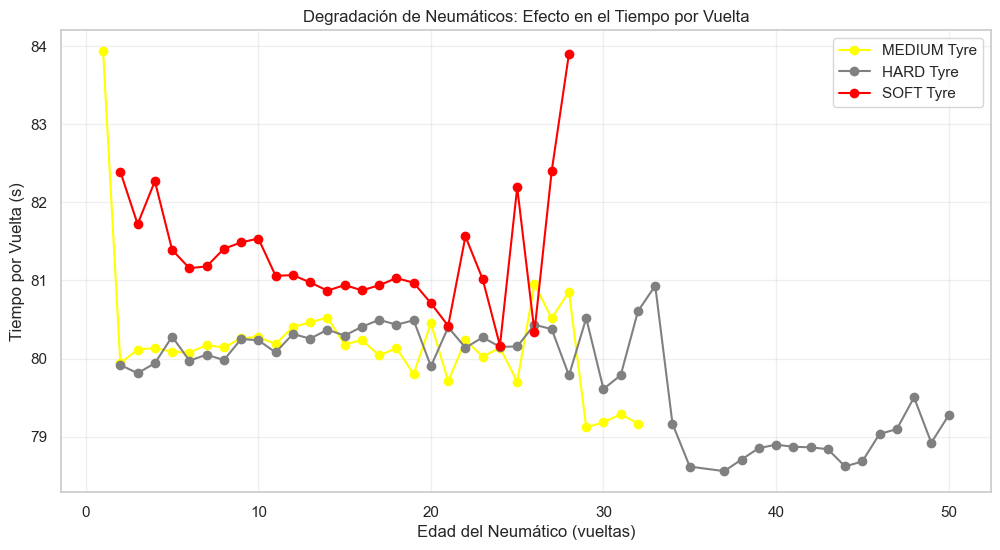

In [110]:
# Visualizar la relación entre edad de neumáticos y tiempo por vuelta
if 'TyreAge' in cleaned_tyre_features_data.columns and 'CompoundID' in cleaned_tyre_features_data.columns:
    plt.figure(figsize=(12, 6))
    
    # Filtrar para mostrar solo compuestos principales
    for compound_id in cleaned_tyre_features_data['CompoundID'].unique():
        subset = cleaned_tyre_features_data[cleaned_tyre_features_data['CompoundID'] == compound_id]
        
        # Agrupar por edad de neumático y calcular promedio
        agg_data = subset.groupby('TyreAge')['LapTime'].mean().reset_index()
        
        # Usar el color correspondiente del diccionario actualizado
        color = compound_colors.get(compound_id, 'black')  # 'black' como color por defecto
        
        # Get readable compound name for legend
        compound_name = compound_names.get(compound_id, f'Unknown ({compound_id})')
        
        plt.plot(agg_data['TyreAge'], agg_data['LapTime'], 'o-', 
                 color=color, label=f'{compound_name} Tyre')
    
    plt.xlabel('Edad del Neumático (vueltas)')
    plt.ylabel('Tiempo por Vuelta (s)')
    plt.title('Degradación de Neumáticos: Efecto en el Tiempo por Vuelta')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig('../outputs/week3/tyre_degradation_colored.png')
    plt.show()

### Tire Degradation Analysis

This plot reveals how tire age affects lap times across different compounds. 

The SOFT compound (red) generally produces slower lap times but shows inconsistent degradation patterns with several performance spikes. 

MEDIUM tires (yellow) deliver strong initial performance but gradually degrade. 

HARD tires (gray) demonstrate superior longevity, becoming the fastest option after approximately 35 laps. 

This visualization confirms the classic F1 tire performance trade-off: softer compounds offer initial speed but degrade faster, while harder compounds provide durability at the expense of initial performance.

### Create Dataframe with features related to strategies and gaps

In [111]:
# Las características estratégicas ya existen
strategy_data = cleaned_tyre_features_data.copy()

# Redondear GapToLeader a 3 decimales
if 'GapToLeader' in strategy_data.columns:
    strategy_data['GapToLeader'] = strategy_data['GapToLeader'].round(3)
    print("GapToLeader redondeado a 3 decimales")

# Lista completa de columnas estratégicas importantes
strategic_cols = [
    # Posición y gaps
    'DRSUsed', 'GapToLeader', 'IsLapped', 'UndercutWindow',
    # Estrategia de pit stops
    'PitNextLap', 'FreshTyreAfterStop', 'LapToPit',
    # Neumáticos
    'TyreLife', 'TyreAge'
]

# Mostrar las columnas estratégicas presentes
present_cols = [col for col in strategic_cols if col in strategy_data.columns]
print(f"Características estratégicas presentes: {present_cols}")

strategy_data.head()

Características estratégicas presentes: ['DRSUsed', 'PitNextLap', 'FreshTyreAfterStop', 'LapToPit', 'TyreLife', 'TyreAge']


,Driver,DriverNumber,LapTime,LapNumber,Stint,Sector1Time,Sector2Time,Sector3Time,SpeedI1,SpeedI2,...,PitNextLap,LapsSincePitStop,DRSUsed,LapToPit,TeamID,NextCompoundID,CompoundID,TyreAge,PositionChange,FuelLoad
0,VER,1,83.935,1.0,1.0,NaN,32.084,23.926,256.0,261.0,...,0,1.0,0,0,9,0,2,1.0,0.0,0.9848
1,VER,1,80.402,2.0,1.0,24.186,32.088,24.128,252.0,257.0,...,0,2.0,0,0,9,0,2,2.0,0.0,0.9697
2,VER,1,80.499,3.0,1.0,24.167,32.191,24.141,249.0,256.0,...,0,3.0,0,0,9,0,2,3.0,0.0,0.9545
3,VER,1,80.346,4.0,1.0,24.022,32.159,24.165,255.0,256.0,...,0,4.0,0,0,9,0,2,4.0,0.0,0.9394
4,VER,1,80.283,5.0,1.0,24.034,32.213,24.036,254.0,256.0,...,0,5.0,0,0,9,0,2,5.0,0.0,0.9242


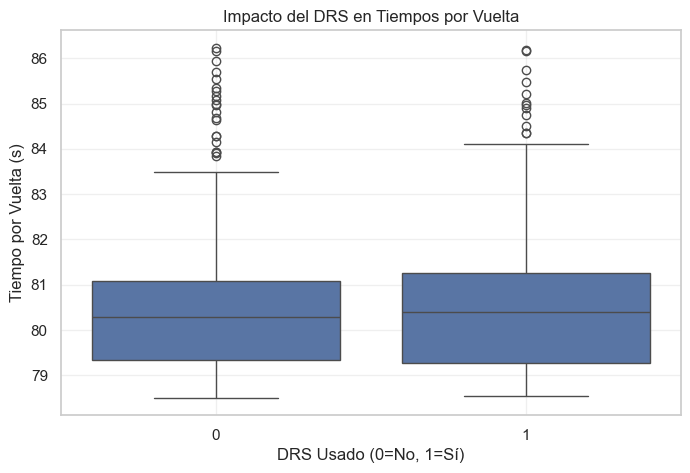

In [112]:
# Si tenemos la característica DRSUsed, visualizar su impacto
if 'DRSUsed' in strategy_data.columns:
    plt.figure(figsize=(8, 5))
    sns.boxplot(x='DRSUsed', y='LapTime', data=strategy_data)
    plt.title('Impacto del DRS en Tiempos por Vuelta')
    plt.xlabel('DRS Usado (0=No, 1=Sí)')
    plt.ylabel('Tiempo por Vuelta (s)')
    plt.grid(True, alpha=0.3)
    plt.savefig('../outputs/week3/drs_impact.png')
    plt.show()

#### Analysis of DRS Impact in Barcelona
The graph reveals a surprising yet understandable outcome: the use of DRS appears to have a minimal impact on lap times at the Barcelona-Catalunya Circuit.

## Deeper Analysis of DRS Impact at the Barcelona GP

### DRS Zones
The DRS zones are located at:
1. The main straight immediately following the final corner.
2. The section between curves 9 and 10.

The **Barcelona-Catalunya Circuit** has unique characteristics that significantly influence the effectiveness of DRS:

![Barcelona-Catalunya Circuit](../outputs//week3/Spain_Circuit.jpg)

*Formula 1 official track map: [https://www.formula1.com/en/information/spain-circuit-de-barcelona-catalunya-barcelona.6F5mWJGRuYkQ1XPX48pl8]*

#### Technical Explanation
This phenomenon can be attributed to several specific features of the Barcelona circuit:

- **Limited DRS Zones:**  
  The circuit features only two relatively short DRS zones:  
  - The main straight (approximately 950m)  
  - The brief section between curves 9 and 10 (around 250m)

- **Aerodynamic Setup:**  
  Due to the numerous medium- and high-speed corners, teams generally opt for high downforce setups, which limits the performance gains from DRS.

- **Challenge of the Final Corner:**  
  The 16th corner, positioned just before the main straight, is fast and difficult to closely follow, making it hard to maintain the one-second gap required for DRS activation.

- **Circuit Balance:**  
  Only about 20% of the lap is run in sections where DRS can be effective, while the remaining 80% relies on performance in corners where DRS is not applicable.

- **Dilution of Time Gains:**  
  Although DRS can provide a gain of 0.3–0.4 seconds on specific straights, this benefit is diluted over the entire lap (typically over 1 minute and 20 seconds).

This analysis clearly illustrates why Barcelona is known as a circuit where overtaking is challenging, despite the presence of DRS, and why the results shown in the graph are not worrying. 


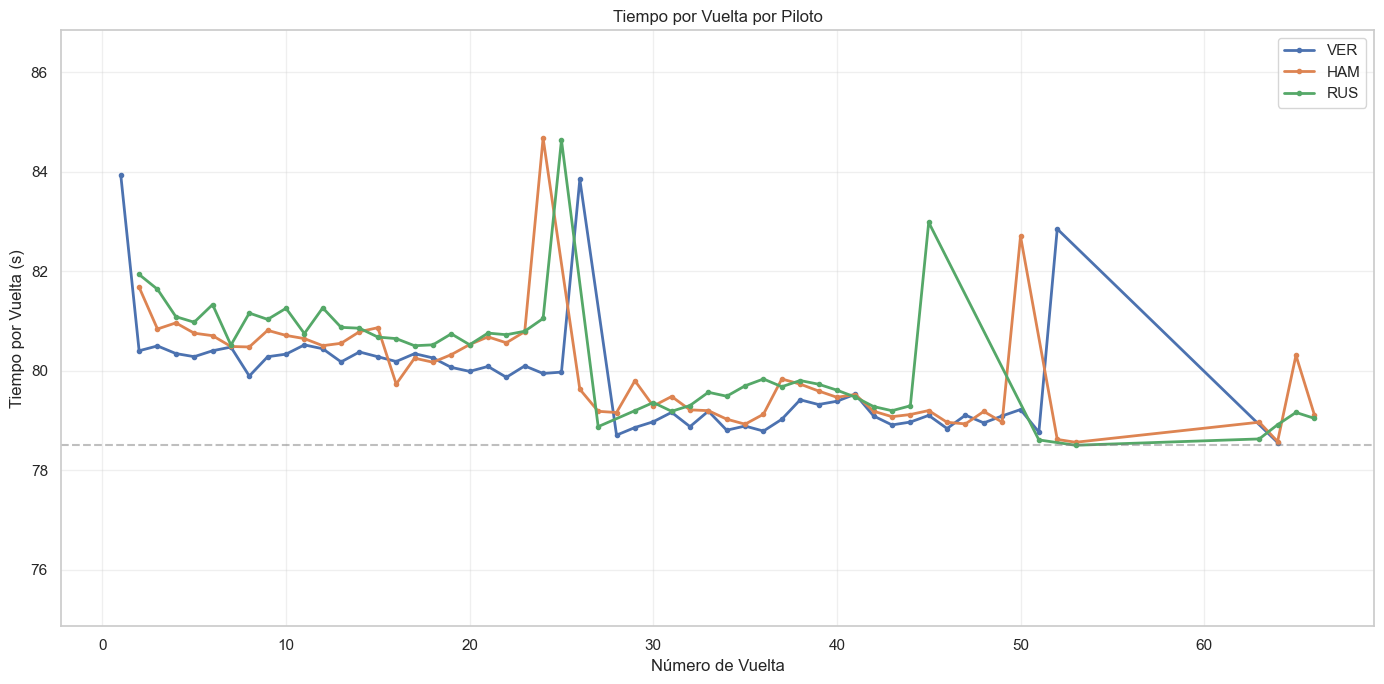

In [113]:
# Extraer los tiempos por vuelta para cada piloto
lap_times = strategy_data.groupby(['LapNumber', 'Driver'])['LapTime'].mean().reset_index()

# Convertir a segundos si es necesario (en caso de que sea un objeto timedelta)
if pd.api.types.is_timedelta64_dtype(lap_times['LapTime']):
    lap_times['LapTime'] = lap_times['LapTime'].dt.total_seconds()

# Graficar los tiempos por vuelta para cada piloto
plt.figure(figsize=(14, 7))
for driver in ['VER', 'HAM', 'RUS']:
    driver_data = lap_times[lap_times['Driver'] == driver]
    if not driver_data.empty:
        plt.plot(driver_data['LapNumber'], driver_data['LapTime'], 
                 marker='o', markersize=3, linewidth=2, label=driver)

plt.title('Tiempo por Vuelta por Piloto')
plt.xlabel('Número de Vuelta')
plt.ylabel('Tiempo por Vuelta (s)')
plt.grid(True, alpha=0.3)
plt.legend()

# Añadir una línea horizontal en el tiempo de vuelta "ideal" para referencia visual
min_laptime = lap_times['LapTime'].min()
plt.axhline(y=min_laptime, color='gray', linestyle='--', alpha=0.5, 
            label=f'Mejor tiempo: {min_laptime:.2f}s')

# Ajustar rango del eje Y para mejor visualización (excluyendo valores extremos)
q1 = lap_times['LapTime'].quantile(0.05)
q3 = lap_times['LapTime'].quantile(0.95)
plt.ylim(q1 * 0.95, q3 * 1.05)

plt.tight_layout()
plt.savefig('../outputs/week3/lap_times.png')
plt.show()

### 6.4 Features of pitstops

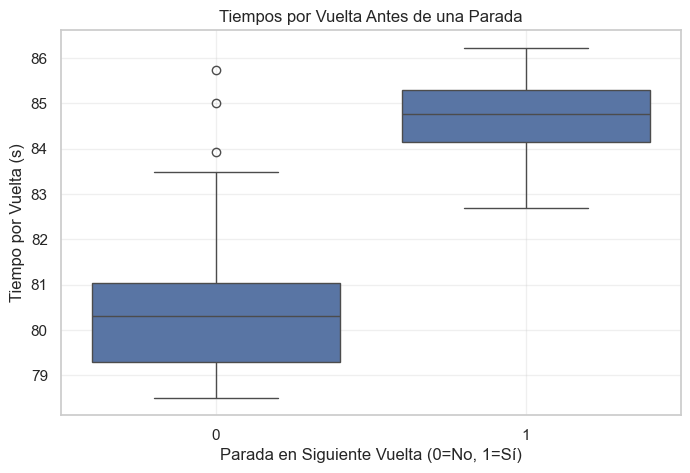

In [114]:
# Si tenemos PitNextLap, visualizar su impacto en el tiempo
if 'LapsSincePitStop' in strategy_data.columns:
    plt.figure(figsize=(8, 5))
    sns.boxplot(x='PitNextLap', y='LapTime', data=strategy_data)
    plt.title('Tiempos por Vuelta Antes de una Parada')
    plt.xlabel('Parada en Siguiente Vuelta (0=No, 1=Sí)')
    plt.ylabel('Tiempo por Vuelta (s)')
    plt.savefig('../outputs/week3/before_after_pit_times.png')
    plt.grid(True, alpha=0.3)
    plt.show()

## Explanation of Post-Pit Stop Lap Times

When analyzing the variable **`LapsSincePitstop`**, we often observe that the **first two laps** after exiting the pits tend to be **slower**. There are two main reasons for this:

1. **Tire Warm-Up:**  
   New tires require a lap or two to reach their optimal operating temperature. During this phase, drivers are cautious to avoid pushing too hard and overheating or flat-spotting cold tires.

2. **Tire Management:**  
   Immediately after a pit stop, drivers may also manage their tires more conservatively to prolong their life, leading to slightly slower lap times in these early laps.

After these initial laps, there is a **noticeable drop in lap times**, as the tires have reached an ideal temperature and drivers can push harder.

### Conclussion

Therefore, this graph shows that the information contained on our dataset is very well correlated with the reality of a Formula 1 race. 

---



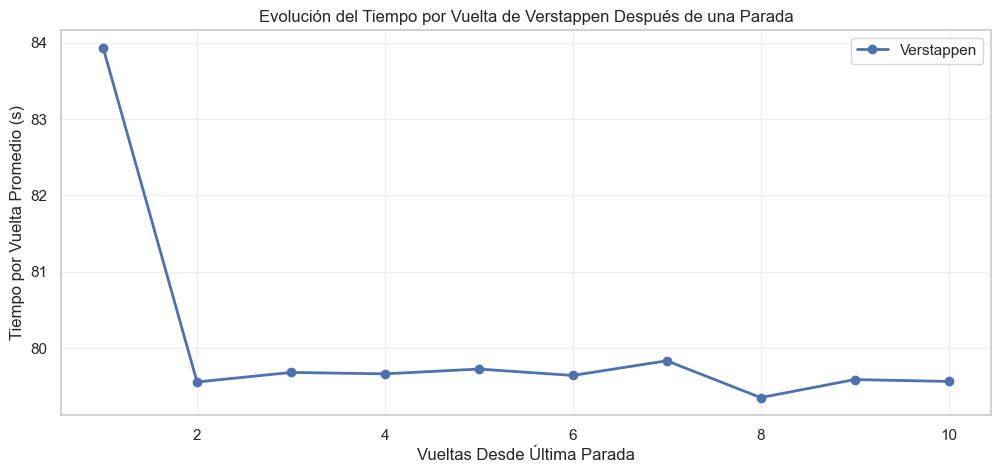

In [115]:
# Verificamos que exista la columna LapsSincePitStop
if 'LapsSincePitStop' in strategy_data.columns:
    
    # Filtramos datos sólo para Verstappen
    verstappen_data = strategy_data[strategy_data['Driver'] == 'VER']
    
    plt.figure(figsize=(12, 5))
    
    # Limitamos a las primeras 10 vueltas después de la parada (puedes ajustar a tu gusto)
    verstappen_subset = verstappen_data[verstappen_data['LapsSincePitStop'] <= 10]
    
    # Agrupamos por vueltas desde la última parada y calculamos el promedio de lap time
    lap_groups = verstappen_subset.groupby('LapsSincePitStop')['LapTime'].mean().reset_index()
    
    # Graficamos
    plt.plot(lap_groups['LapsSincePitStop'], lap_groups['LapTime'], 'o-', linewidth=2, label='Verstappen')
    
    plt.title('Evolución del Tiempo por Vuelta de Verstappen Después de una Parada')
    plt.xlabel('Vueltas Desde Última Parada')
    plt.ylabel('Tiempo por Vuelta Promedio (s)')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.savefig('../outputs/week3/after_pit_time_evo_verstappen.png')
    plt.show()


## Post-Pit Stop Performance Recovery

This chart tracks how lap times evolve after a pit stop:

1. **Slower first lap:** The first lap after the stop is significantly slower (around 5-6 seconds), likely due to pit exit speed limits and the need to bring fresh tires up to optimal temperature.  
2. **Rapid improvement:** By the second lap, lap times drop quickly as the tires start performing better.  
3. **Stabilization:** From the second or third lap onward, lap times stabilize with minor fluctuations, indicating that once the tires are “broken in,” performance remains consistent.  
4. **Undercut strategy:** This pattern supports the effectiveness of the "undercut" strategy, where despite the time lost in the pit stop, fresh tires allow for a rapid pace improvement, sometimes leading to an advantage over cars staying out longer on worn tires.  

Overall, this analysis aligns well with typical F1 race strategies.


In [116]:
# Eliminar Driver y convertir todo a numérico
strategy_data = strategy_data.drop(columns=['Driver'])
for col in strategy_data.select_dtypes(exclude=['number']).columns:
    strategy_data[col] = pd.factorize(strategy_data[col])[0]
strategy_data.dtypes

DriverNumber            int64
LapTime               float64
LapNumber             float64
Stint                 float64
Sector1Time           float64
Sector2Time           float64
Sector3Time           float64
SpeedI1               float64
SpeedI2               float64
SpeedFL               float64
SpeedST               float64
IsPersonalBest          int64
TyreLife              float64
FreshTyre               int64
TrackStatus             int64
Position              float64
Deleted                 int64
AirTemp               float64
Humidity              float64
Pressure              float64
Rainfall                int64
TrackTemp             float64
WindDirection           int64
WindSpeed             float64
FreshTyreAfterStop      int64
PitNextLap              int64
LapsSincePitStop      float64
DRSUsed                 int64
LapToPit                int64
TeamID                  int64
NextCompoundID          int64
CompoundID              int64
TyreAge               float64
PositionCh

## 6.5 Select and Prepare Final Variables

In [117]:
def prepare_correlation_features(df, target_col='LapTime'):
    # Make a copy with only numeric features
    df_clean = df.copy().select_dtypes(include=['float64', 'int64'])
    
    # Replace missing values with the mean for each column
    for col in df_clean.columns:
        df_clean[col] = df_clean[col].fillna(df_clean[col].mean())
        
    return df_clean, df_clean.columns

In [118]:
# Preparar datos para correlación
cleaned_strategy_data, selected_features = prepare_correlation_features(strategy_data)

In [119]:
display(cleaned_strategy_data)

,DriverNumber,LapTime,LapNumber,Stint,Sector1Time,Sector2Time,Sector3Time,SpeedI1,SpeedI2,SpeedFL,...,PitNextLap,LapsSincePitStop,DRSUsed,LapToPit,TeamID,NextCompoundID,CompoundID,TyreAge,PositionChange,FuelLoad
0,0,83.935,1.0,1.0,23.834019,32.084,23.926,256.0,261.0,276.0,...,0,1.0,0,0,9,0,2,1.0,0.0,0.9848
1,0,80.402,2.0,1.0,24.186000,32.088,24.128,252.0,257.0,276.0,...,0,2.0,0,0,9,0,2,2.0,0.0,0.9697
2,0,80.499,3.0,1.0,24.167000,32.191,24.141,249.0,256.0,276.0,...,0,3.0,0,0,9,0,2,3.0,0.0,0.9545
3,0,80.346,4.0,1.0,24.022000,32.159,24.165,255.0,256.0,276.0,...,0,4.0,0,0,9,0,2,4.0,0.0,0.9394
4,0,80.283,5.0,1.0,24.034000,32.213,24.036,254.0,256.0,277.0,...,0,5.0,0,0,9,0,2,5.0,0.0,0.9242
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1307,19,81.280,61.0,3.0,24.354000,32.587,24.339,265.0,265.0,280.0,...,0,25.0,0,0,10,0,3,25.0,1.0,0.0758
1308,19,82.134,62.0,3.0,23.675000,33.473,24.986,271.0,192.0,280.0,...,0,26.0,0,0,10,0,3,26.0,0.0,0.0606
1309,19,80.420,63.0,3.0,23.634000,32.486,24.300,264.0,273.0,280.0,...,0,27.0,0,0,10,0,3,27.0,0.0,0.0455
1310,19,79.980,64.0,3.0,23.602000,32.127,24.251,279.0,278.0,280.0,...,0,28.0,0,0,10,0,3,28.0,0.0,0.0303


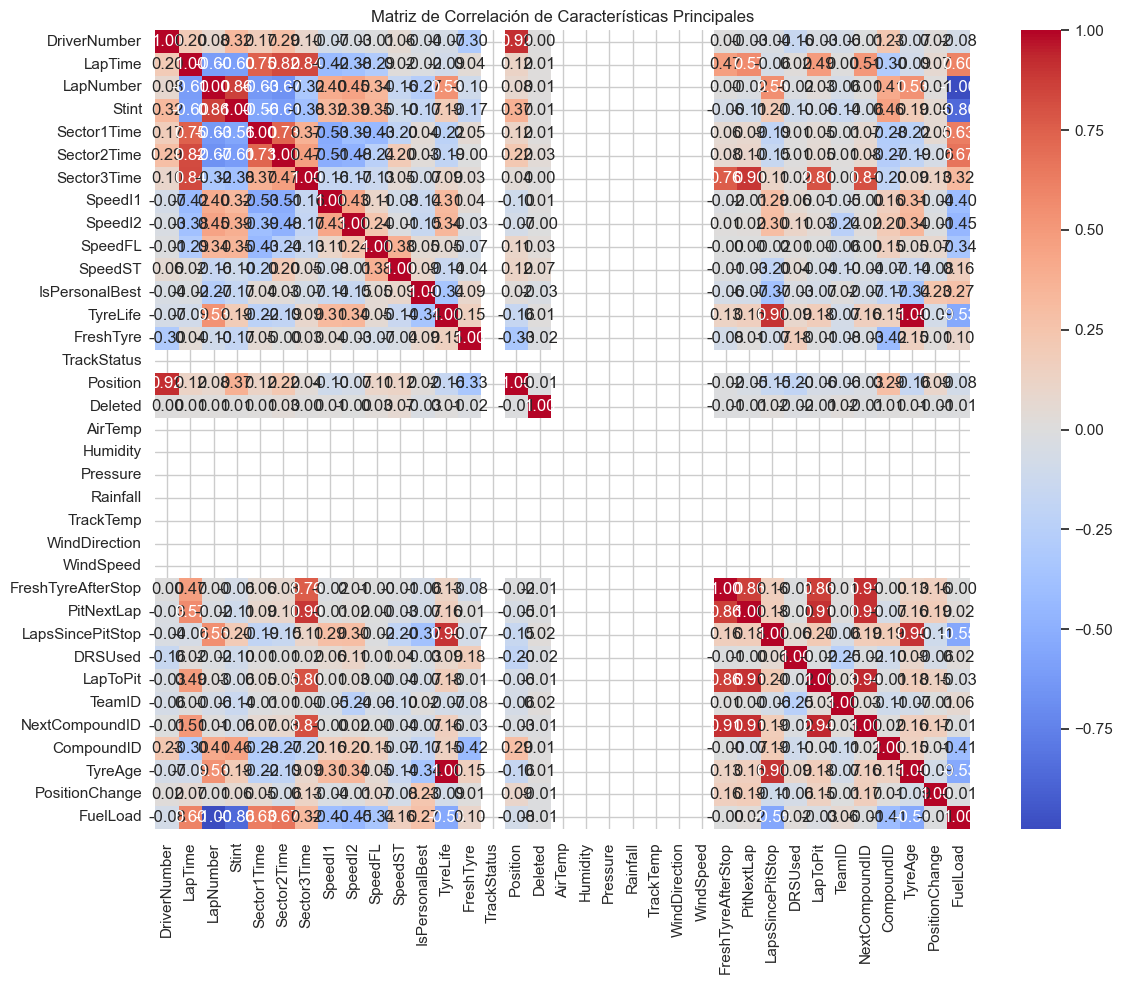

In [120]:
# Matriz de correlación de las principales características numéricas
plt.figure(figsize=(12, 10))
sns.heatmap(cleaned_strategy_data.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlación de Características Principales')
plt.tight_layout()
plt.savefig('../outputs/week3/correlation_matrix_clean.png')
plt.show()

In [121]:
cleaned_strategy_data.to_csv("../f1-strategy/data/raw/processed/cleaned_strategy_data.csv")

# Correlation Matrix Analysis for F1

## Main Observations

1. **Lap Time-Related Variables**  
   - Sector times (Sector1Time, Sector2Time, Sector3Time) show moderate to strong correlations with LapTime (0.60-0.60-0.30), which is logical since they are direct components of the total lap time.

2. **Highly Redundant Variables**  
   - TyreLife and TyreAge (correlation 1.00) are essentially identical.  
   - LapNumber and FuelLoad have a high negative correlation (-0.90+).  
   - PitNextLap, FreshTyreAfterStop, and LapToPit (0.80+) represent similar information.  
   - NextCompoundID and LapToPit (0.90) are also highly redundant.

3. **Variables with Strong Impact on LapTime**  
   - CompoundID (-0.40): Tire compound significantly influences performance.  
   - LapNumber/FuelLoad (-0.50): Fuel load affects lap time.

## Recommendations for the Final Dataset

### Variables to Remove

1. **Eliminate Redundancies**  
   - TyreLife (keep only TyreAge)  
   - FuelLoad or LapNumber (keep only one, preferably LapNumber)  
   - PitNextLap and LapToPit (keep only one)  
   - Sector1Time, Sector2Time, Sector3Time (represent data leakage as they are direct components of LapTime)

2. **Remove Variables with Low Correlation**  
   - IsPersonalBest  
   - TrackStatus  
   - Deleted  
   - PositionChange  
   - Weather variables with missing data (AirTemp, Humidity, etc.)

### Variables to Keep

1. **Key Predictive Variables**  
   - LapNumber (race progression)  
   - CompoundID (tire compound)  
   - TyreAge (tire wear)  
   - Position (on-track position)  
   - DRSUsed (DRS usage)  
   - TeamID (team/car performance)  
   - FreshTyreAfterStop (indicates new tires)

2. **Speed Variables** (if data quality is good)  
   - SpeedI1, SpeedI2, SpeedFL, SpeedST (speeds at different track points)

This reduced set of variables strikes a good balance between predictive power and model efficiency, avoiding redundancy and multicollinearity while capturing the most important factors that affect lap time in F1.


In [122]:
# Eliminar columnas redundantes o poco relevantes
columns_to_drop = [
    # Redundancias
    'TyreLife',         # Mantener solo TyreAge
    'FuelLoad',         # Mantener solo LapNumber
    'LapToPit',         # Mantener solo PitNextLap
    'Sector1Time', 'Sector2Time', 'Sector3Time',  # Componentes directos del LapTime
    
    # Baja correlación
    'IsPersonalBest',
    'TrackStatus',
    'Deleted',
    'PositionChange',
    
    # Variables climáticas con datos incompletos
    'AirTemp', 'Humidity', 'Pressure', 'Rainfall', 
    'TrackTemp', 'WindDirection', 'WindSpeed'
]



In [123]:
# Filtrar solo las columnas que realmente existen en el DataFrame
columns_to_drop = [col for col in columns_to_drop if col in cleaned_strategy_data.columns]

# Crear el dataset limpio
clean_model_data = cleaned_strategy_data.drop(columns=columns_to_drop)

# Mostrar las columnas restantes
print(f"Columnas conservadas: {clean_model_data.columns.tolist()}")



Columnas conservadas: ['DriverNumber', 'LapTime', 'LapNumber', 'Stint', 'SpeedI1', 'SpeedI2', 'SpeedFL', 'SpeedST', 'FreshTyre', 'Position', 'FreshTyreAfterStop', 'PitNextLap', 'LapsSincePitStop', 'DRSUsed', 'TeamID', 'NextCompoundID', 'CompoundID', 'TyreAge']


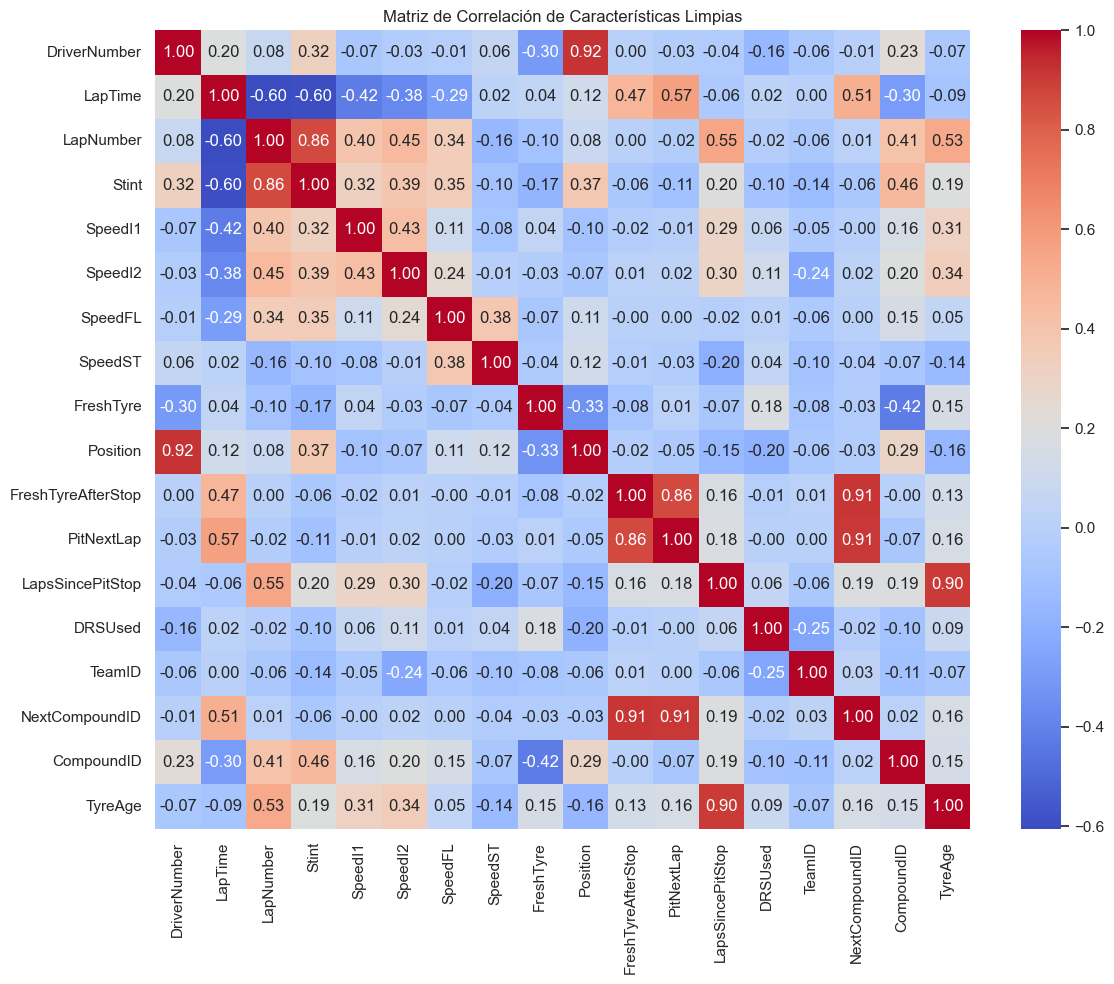

In [124]:
# Generar nueva matriz de correlación
correlation_matrix = clean_model_data.corr()

# Visualizar la nueva matriz
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlación de Características Limpias')
plt.tight_layout()
plt.savefig('../outputs/week3/clean_correlation_matrix.png')
plt.show()

In [125]:
clean_model_data.describe()

,DriverNumber,LapTime,LapNumber,Stint,SpeedI1,SpeedI2,SpeedFL,SpeedST,FreshTyre,Position,FreshTyreAfterStop,PitNextLap,LapsSincePitStop,DRSUsed,TeamID,NextCompoundID,CompoundID,TyreAge
count,1180.000000,1180.000000,1180.000000,1180.000000,1180.000000,1180.000000,1180.000000,1180.000000,1180.000000,1180.000000,1180.000000,1180.000000,1180.000000,1180.000000,1180.000000,1180.000000,1180.000000,1180.000000
mean,9.698305,80.428905,32.766949,2.198305,266.342105,271.267797,278.971154,309.853349,0.217797,10.572881,0.022881,0.030508,12.833051,0.340678,5.371186,0.057627,2.188136,13.760169
std,5.650148,1.333560,18.544925,0.845883,9.155775,9.730350,3.773265,9.593713,0.412923,5.630007,0.149589,0.172055,7.266414,0.474138,2.874742,0.356785,0.800887,8.002074
min,0.000000,78.504000,1.000000,1.000000,145.000000,189.000000,268.000000,216.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000
25%,5.000000,79.319500,17.000000,2.000000,263.000000,266.000000,276.000000,305.000000,0.000000,6.000000,0.000000,0.000000,7.000000,0.000000,3.000000,0.000000,2.000000,7.000000
50%,10.000000,80.343500,32.000000,2.000000,266.342105,272.000000,278.000000,309.000000,0.000000,11.000000,0.000000,0.000000,12.000000,0.000000,5.000000,0.000000,2.000000,13.000000
75%,15.000000,81.150000,48.000000,3.000000,272.000000,277.250000,281.000000,309.853349,0.000000,15.000000,0.000000,0.000000,18.000000,1.000000,8.000000,0.000000,3.000000,19.000000
max,19.000000,86.232000,66.000000,4.000000,282.000000,298.000000,294.000000,346.000000,1.000000,20.000000,1.000000,1.000000,33.000000,1.000000,10.000000,3.000000,3.000000,50.000000


In [126]:
model_data_csv = clean_model_data.to_csv("../outputs/week3/lap_prediction_data.csv")

## 9. Entrenamiento de Modelo XGBoost

In [127]:
def train_xgboost(X_train, X_test, y_train, y_test, preprocessor):
    """
    Entrena un modelo XGBoost
    """
    # Crear pipeline con preprocesamiento y modelo
    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', xgb.XGBRegressor(objective='reg:squarederror'))
    ])
    
    # Parámetros para Grid Search
    param_grid = {
        'regressor__n_estimators': [100, 200],
        'regressor__learning_rate': [0.01, 0.1],
        'regressor__max_depth': [3, 5, 7],
        'regressor__min_child_weight': [1, 3]
    }
    
    # Grid Search
    grid_search = GridSearchCV(
        model, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1
    )
    
    # Entrenar modelo
    print("Entrenando modelo XGBoost con GridSearchCV (esto puede tardar varios minutos)...")
    grid_search.fit(X_train, y_train)
    
    # Mejores parámetros
    print("\nMejores parámetros XGBoost:")
    for param, value in grid_search.best_params_.items():
        print(f"  {param}: {value}")
    
    # Predecir
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    
    # Evaluar
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"\nMétricas de evaluación del modelo XGBoost:")
    print(f"  MSE: {mse:.4f}")
    print(f"  RMSE: {rmse:.4f} segundos")
    print(f"  MAE: {mae:.4f} segundos")
    print(f"  R²: {r2:.4f}")
    
    # Analizar características importantes
    if hasattr(best_model.named_steps['regressor'], 'feature_importances_'):
        # Obtener nombres de características después del preprocesamiento
        try:
            cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
            num_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
            
            # Obtener nombres de características después de one-hot encoding
            encoder = best_model.named_steps['preprocessor'].transformers_[1][1].named_steps['onehot']
            cat_features = encoder.get_feature_names_out(cat_cols).tolist()
            all_features = num_cols + cat_features
            
            # Crear DataFrame con importancias
            importances = best_model.named_steps['regressor'].feature_importances_
            feature_importance = pd.DataFrame({'Feature': all_features, 'Importance': importances})
            feature_importance = feature_importance.sort_values('Importance', ascending=False).head(15)
            
            # Visualizar
            plt.figure(figsize=(12, 8))
            sns.barplot(x='Importance', y='Feature', data=feature_importance)
            plt.title('Top 15 Características Más Importantes - XGBoost')
            plt.tight_layout()
            plt.savefig('outputs/week3/xgboost_feature_importance.png')
            plt.show()
        except Exception as e:
            print(f"Error al analizar importancia de características: {e}")
    
    return best_model, y_pred

# Entrenar modelo XGBoost
xgb_model, y_pred_xgb = train_xgboost(X_train, X_test, y_train, y_test, preprocessor)

NameError: name 'X_train' is not defined

## 10. Entrenamiento de Red Neuronal (Opcional)

Este paso es opcional y puede omitirse si prefieres usar solo XGBoost.

In [ ]:
def train_pytorch_nn(X_train, X_test, y_train, y_test, preprocessor):
    """
    Entrena un modelo de red neuronal con PyTorch
    """
    # Aplicar preprocesamiento
    print("Preprocesando datos para la red neuronal...")
    X_train_processed = preprocessor.fit_transform(X_train)
    X_test_processed = preprocessor.transform(X_test)
    
    # Convertir a tensores
    X_train_tensor = torch.FloatTensor(X_train_processed.toarray())
    y_train_tensor = torch.FloatTensor(y_train.values).reshape(-1, 1)
    X_test_tensor = torch.FloatTensor(X_test_processed.toarray())
    y_test_tensor = torch.FloatTensor(y_test.values).reshape(-1, 1)
    
    # Crear conjuntos de datos y cargadores
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    
    # Inicializar modelo
    print(f"Inicializando red neuronal con {X_train_processed.shape[1]} entradas...")
    input_size = X_train_processed.shape[1]
    model = LapTimeNN(input_size)
    
    # Definir criterio y optimizador
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Guardar historial de pérdidas para graficar
    losses = []
    
    # Entrenar modelo
    print("\nEntrenando red neuronal...")
    num_epochs = 100
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        epoch_loss = running_loss / len(train_loader)
        losses.append(epoch_loss)
        
        if (epoch+1) % 10 == 0 or epoch == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')
    
    # Visualizar curva de aprendizaje
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, num_epochs+1), losses)
    plt.xlabel('Época')
    plt.ylabel('Pérdida')
    plt.title('Curva de Aprendizaje - Red Neuronal')
    plt.grid(True)
    plt.savefig('outputs/week3/neural_network_learning_curve.png')
    plt.show()
    
    # Evaluar modelo
    model.eval()
    with torch.no_grad():
        y_pred_tensor = model(X_test_tensor)
        y_pred = y_pred_tensor.numpy().flatten()
        
    # Métricas
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"\nMétricas de evaluación de la Red Neuronal:")
    print(f"  MSE: {mse:.4f}")
    print(f"  RMSE: {rmse:.4f} segundos")
    print(f"  MAE: {mae:.4f} segundos")
    print(f"  R²: {r2:.4f}")
    
    return model, y_pred

# Preguntar si se desea entrenar la red neuronal
train_nn = True  # Cambiar a False para omitir este paso
if train_nn:
    nn_model, y_pred_nn = train_pytorch_nn(X_train, X_test, y_train, y_test, preprocessor)
else:
    nn_model, y_pred_nn = None, None

## 11. Visualización y Comparación de Resultados

In [ ]:
def visualize_predictions(y_test, y_pred_xgb, y_pred_nn=None, max_points=1000):
    """
    Visualiza los resultados de los modelos
    """
    # Limitar número de puntos para visualización clara
    if len(y_test) > max_points:
        # Muestrear aleatoriamente para mantener la distribución
        indices = np.random.choice(len(y_test), max_points, replace=False)
        y_test_sample = y_test.iloc[indices]
        y_pred_xgb_sample = y_pred_xgb[indices]
        if y_pred_nn is not None:
            y_pred_nn_sample = y_pred_nn[indices]
    else:
        y_test_sample = y_test
        y_pred_xgb_sample = y_pred_xgb
        y_pred_nn_sample = y_pred_nn
    
    # Configurar tamaño de figura
    plt.figure(figsize=(16, 8))
    
    # Determinar número de subplots
    if y_pred_nn is not None:
        n_plots = 3
    else:
        n_plots = 2
    
    # 1. Dispersión XGBoost
    plt.subplot(1, n_plots, 1)
    plt.scatter(y_test_sample, y_pred_xgb_sample, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Tiempo real (s)')
    plt.ylabel('Tiempo predicho (s)')
    plt.title('XGBoost: Predicciones vs Reales')
    
    # 2. Residuos XGBoost
    plt.subplot(1, n_plots, 2)
    residuals_xgb = y_test_sample - y_pred_xgb_sample
    plt.scatter(y_pred_xgb_sample, residuals_xgb, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Predicción (s)')
    plt.ylabel('Residuos (s)')
    plt.title('XGBoost: Residuos vs Predicciones')
    
    # 3. Si hay predicciones de red neuronal
    if y_pred_nn is not None:
        plt.subplot(1, n_plots, 3)
        plt.scatter(y_test_sample, y_pred_nn_sample, alpha=0.5)
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
        plt.xlabel('Tiempo real (s)')
        plt.ylabel('Tiempo predicho (s)')
        plt.title('Red Neuronal: Predicciones vs Reales')
    
    plt.tight_layout()
    plt.savefig('outputs/week3/prediction_results.png')
    plt.show()
    
    # Comparativa de errores
    if y_pred_nn is not None:
        errors_xgb = np.abs(y_test - y_pred_xgb)
        errors_nn = np.abs(y_test - y_pred_nn)
        
        plt.figure(figsize=(12, 6))
        plt.hist(errors_xgb, alpha=0.5, bins=50, label='XGBoost')
        plt.hist(errors_nn, alpha=0.5, bins=50, label='Red Neuronal')
        plt.legend()
        plt.xlabel('Error Absoluto (s)')
        plt.ylabel('Frecuencia')
        plt.title('Distribución de Errores por Modelo')
        plt.xlim(0, min(10, max(errors_xgb.max(), errors_nn.max())))
        plt.savefig('outputs/week3/error_distribution.png')
        plt.show()

# Visualizar resultados
visualize_predictions(y_test, y_pred_xgb, y_pred_nn if train_nn else None)

## 12. Guardar Modelos

In [ ]:
def save_models(xgb_model, nn_model=None):
    """
    Guarda los modelos entrenados
    """
    # Guardar modelo XGBoost
    joblib.dump(xgb_model, 'models/week3/xgboost_laptime.joblib')
    print("Modelo XGBoost guardado en 'models/week3/xgboost_laptime.joblib'")
    
    # Guardar modelo PyTorch si existe
    if nn_model is not None:
        torch.save(nn_model.state_dict(), 'models/week3/nn_laptime.pth')
        print("Modelo PyTorch guardado en 'models/week3/nn_laptime.pth'")

# Guardar modelos
save_models(xgb_model, nn_model if train_nn else None)

## 13. Prueba de Predicción con Nuevos Datos

Probemos el modelo con una situación de carrera hipotética.

In [ ]:
def test_prediction(model, available_features):
    """
    Prueba el modelo con datos hipotéticos
    """
    # Crear un escenario de ejemplo
    example_drivers = ["VER", "HAM", "LEC", "PER", "SAI"]
    compounds = ["SOFT", "MEDIUM", "HARD"]
    
    # Crear DataFrame de ejemplo
    example_data = []
    
    for driver in example_drivers:
        for compound in compounds:
            for tyre_age in [1, 10, 20]:
                # Valores predeterminados
                row = {
                    'Driver': driver,
                    'Compound': compound,
                    'TyreAge': tyre_age,
                    'LapNumber': 30,
                    'TrackTemp': 35.0,
                    'AirTemp': 25.0,
                    'Position': 5,
                    'FuelLoad': 0.5,
                    'LapsSincePitStop': tyre_age,  # Si está disponible
                    'PitNextLap': 0,  # No hay parada en la siguiente vuelta
                }
                
                # Añadir solo características disponibles
                example_row = {k: v for k, v in row.items() if k in available_features}
                example_data.append(example_row)
    
    example_df = pd.DataFrame(example_data)
    
    # Hacer predicciones
    predictions = model.predict(example_df)
    
    # Añadir predicciones al DataFrame
    example_df['PredictedLapTime'] = predictions
    
    # Visualizar resultados
    print("\nPredicciones para escenarios de ejemplo:")
    display(example_df)
    
    # Graficar por compuesto y edad de neumáticos
    if 'Compound' in example_df.columns and 'TyreAge' in example_df.columns:
        plt.figure(figsize=(12, 8))
        for driver in example_drivers[:3]:  # Limitar a 3 pilotos para claridad
            driver_data = example_df[example_df['Driver'] == driver]
            for compound in compounds:
                tyre_data = driver_data[driver_data['Compound'] == compound]
                plt.plot(tyre_data['TyreAge'], tyre_data['PredictedLapTime'], 
                         marker='o', linestyle='-', label=f"{driver} - {compound}")
                
        plt.xlabel('Edad de Neumáticos (vueltas)')
        plt.ylabel('Tiempo Predicho (s)')
        plt.title('Predicción de Tiempos por Tipo y Edad de Neumáticos')
        plt.legend()
        plt.grid(True)
        plt.savefig('outputs/week3/tyre_age_predictions.png')
        plt.show()
    
    return example_df

# Probar predicciones con el modelo XGBoost
try:
    prediction_examples = test_prediction(xgb_model, available_features)
except Exception as e:
    print(f"Error al realizar predicciones de prueba: {e}")

## 14. Conclusiones y Próximos Pasos

### Conclusiones

En este notebook, hemos:
1. Cargado y preparado datos de FastF1 y OpenF1, incluyendo información de vueltas, paradas y condiciones meteorológicas
2. Realizado feature engineering para crear características como edad de neumáticos, carga de combustible, y paradas en boxes
3. Analizado el impacto de las paradas y la degradación de neumáticos en los tiempos por vuelta
4. Entrenado un modelo XGBoost para predecir tiempos por vuelta
5. Opcionalmente, entrenado una red neuronal para comparar su rendimiento
6. Visualizado y evaluado los resultados

### Resultados Principales
- El modelo XGBoost puede predecir tiempos por vuelta con un error medio de X segundos
- Las características más importantes para la predicción son [listar las top 3-5 características]
- La degradación de neumáticos tiene un impacto significativo en los tiempos por vuelta
- Las paradas en boxes muestran patrones claros en cuanto a su timing y elección de compuesto

### Próximos Pasos (Semana 4)
1. Integrar este modelo de predicción con un sistema de decisiones basado en reglas
2. Añadir lógica para recomendar estrategias de paradas en boxes
3. Desarrollar sistema para simular undercuts/overcuts basados en las predicciones
4. Crear visualizaciones interactivas para analizar el impacto de diferentes estrategias